<a href="https://colab.research.google.com/github/SandumiJay/Hybrid-CNN-LNN-Model/blob/16-09-2024/CNN_RNN_with_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#install required libraries
!pip install -r '/content/drive/MyDrive/requirements.txt'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.7 MB/s eta 0:00:00
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18041 sha256=32b1a96a396ac541e43be62b4fc49f65958bcc5ad6d841e94afb760fc5bc21dd
  Stored in directory: /root/.cache/pip/wheels/88/e5/dd/0096092515d7a3711c1bbc6c2ea1933a1fe1a62da93a6072a0
Successfully built httplib2shim
  Attempting uninstall: w

In [3]:
train_file_pattern = '/content/drive/MyDrive/wildfirex_datset/next_day_wildfire_spread_train*'
val_file_pattern = '/content/drive/MyDrive/wildfirex_datset/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/drive/MyDrive/wildfirex_datset/next_day_wildfire_spread_test*'


BATCH_SIZE = 32

In [4]:
import os
import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import h5py
import time

import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import immutabledict

import tensorflow as tf
import numpy as np

from tqdm import tqdm
from typing import Callable, Tuple
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss

In [5]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.1298, 7.8760, -0.0053, 2.6823),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.5304, 1.7398051, 4.4828),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.3298, 72.5985),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.9489, 281.08768, 8.9824),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.0923, 295.17383, 9.8155),
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.0243, 3.8501, 1.4110),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.2489, 37.3263, 20.8460),
    # Population
    # min, 99.9 percentile
    'population': (0., 2534.0630, 25.5314, 154.7233),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}


In [6]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img


In [7]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '[a-zA-Z]+'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'[a-zA-Z]+', key)
  if match:
    return match.group(1)
  raise ValueError(f'The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [8]:
train_dataset = get_dataset(
      train_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [9]:
train_inputs, train_labels = next(iter(train_dataset))

In [10]:
val_dataset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [11]:
val_inputs, val_labels = next(iter(val_dataset))

In [12]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [13]:
n_rows = 5
n_features = train_inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

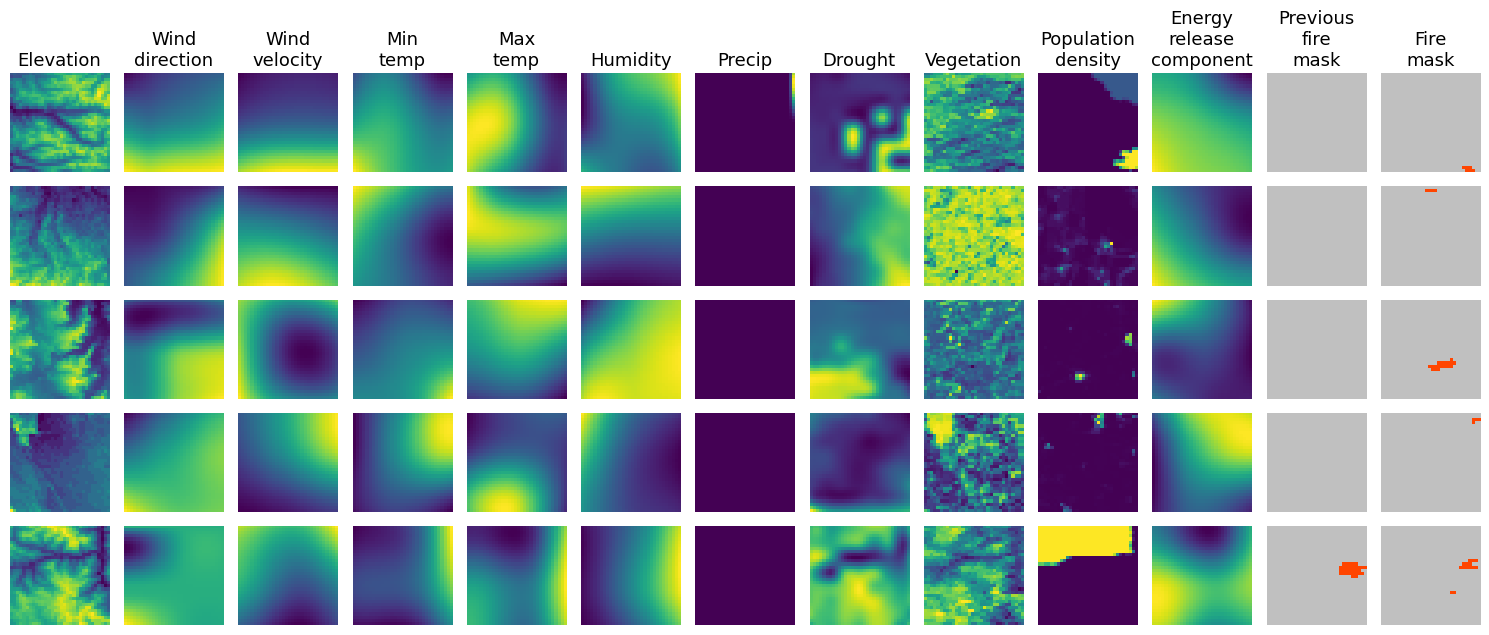

In [15]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(train_inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(train_inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(train_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

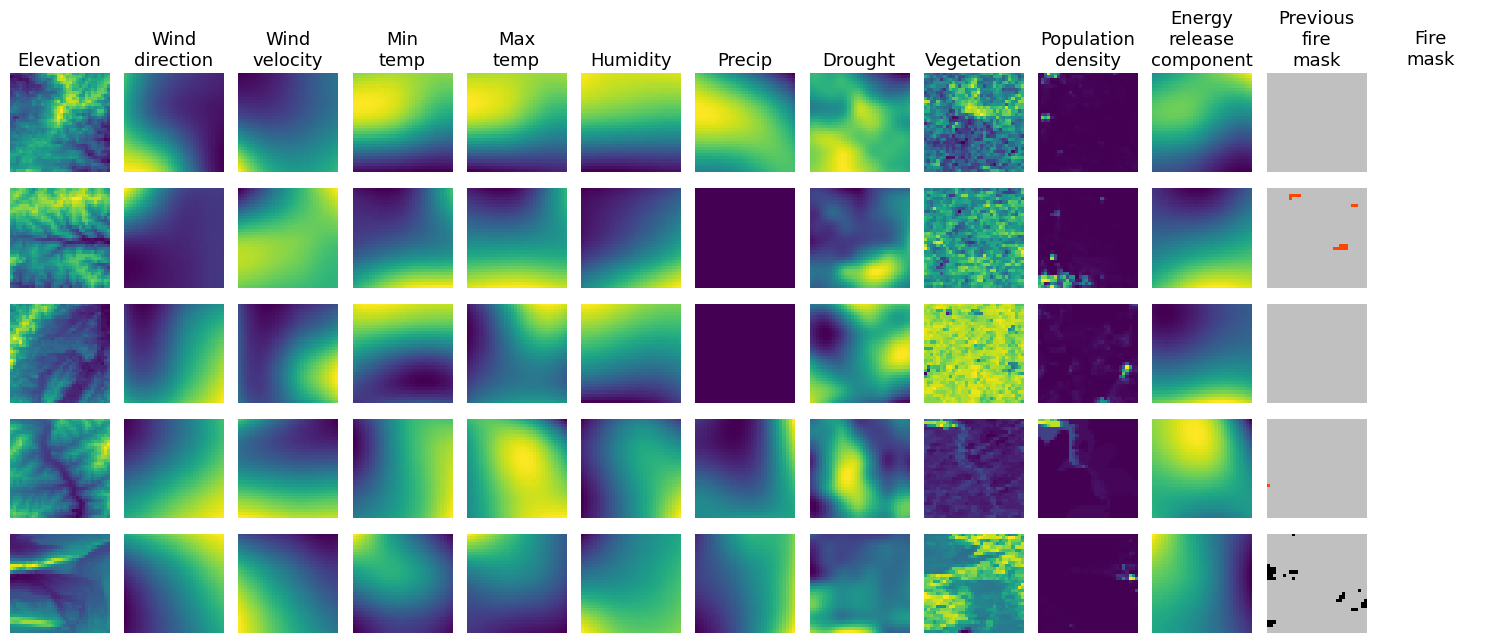

In [34]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(val_inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(val_inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

In [93]:
# Custom callback function to save the model's weights based on validation accuracy
class SaveBestWeights(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1):
        super(SaveBestWeights, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.save_weights_only = save_weights_only
        self.mode = mode
        self.verbose = verbose
        self.best = -np.Inf if mode == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print("Warning: Can't save best weights. No {} found.".format(self.monitor))
        else:
            if self.mode == 'max' and current > self.best:
                if self.verbose > 0:
                    print("\nValidation {} improved from {:.5f} to {:.5f}, saving weights.".format(self.monitor, self.best, current))
                self.best = current
                # Save the trainable parameters of the MobileNetV2 Layers
                Mobile_NetModel = tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer(name='reshape_18').output)
                Mobile_NetModel.save("CNN_weights_1.h5")

                # Save the trainable parameters of the CfC-NCP layer as NumPy arrays using pickle
                ncp_weights = self.model.get_layer(name='cf_c_5').get_weights()
                pickle.dump(ncp_weights, open('CfC_NCP_weights_1.pkl', 'wb'))

                # Save the weights of the last dense layer
                last_dense_layer_weights = self.model.get_layer('dense_5').get_weights()
                pickle.dump(last_dense_layer_weights, open('last_dense_layer_weights_1.pkl', 'wb'))


In [25]:
train_labels = np.squeeze(train_labels)
val_labels = np.squeeze(val_labels)

In [26]:
train_labels.shape

(100, 32, 32)

In [18]:
!pip install ncps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.7 MB/s eta 0:00:00


In [29]:
from tensorflow_examples.models.pix2pix import pix2pix

def build_CNN_AE_model() -> Model:
    """
    Create CNN auto encode model.

    Returns:
        (Model): Keras model.
    """
    base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12], include_top=False, weights=None)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 32x32
        'block_3_expand_relu',   # 16x16
        'block_6_expand_relu',   # 8x8
        'block_13_expand_relu',  # 4x4
        'block_16_project',      # 2x2
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = True

    up_stack = [
        pix2pix.upsample(512, 3),  # 2x2 -> 4x4
        pix2pix.upsample(256, 3),  # 4x4 -> 8x8
        pix2pix.upsample(128, 3),  # 8x8 -> 16x16
        pix2pix.upsample(64, 3),   # 16x16 -> 32x32
    ]

    inputs = tf.keras.layers.Input(shape=[32, 32, 12])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [30]:
train_labels.shape

(100, 32, 32)

In [31]:

print('Label: ',train_labels.shape) # (Batch size, n_rows,n_cols,n_channels)
print('Input: ',train_inputs.shape)

Label:  (100, 32, 32)
Input:  (100, 32, 32, 12)


In [94]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from ncps.wirings import AutoNCP
from ncps.tf import CfC
import pickle
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(include_top=False, weights=None, input_shape=(32, 32, 12))

print(base_model.summary())

# CfC Layer with NCP implemented
ncp = CfC(36, AutoNCP(128, 32))

# Build a new model on top of the base MobileNetV2 model
model = Sequential([
    base_model,
    Reshape((1, 1280)),
    ncp,
    Dense(1024, activation='softmax'),  # Example dense layer
    Reshape((32, 32, 1))

    # Add more layers as needed
])

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Define the temporary filepath to save the best weights
best_weights_filepath = 'best_weights.h5'

# Define the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
save_best_weights_callback = SaveBestWeights(best_weights_filepath)

# Train the model with the callbacks
print(train_inputs.shape)
print(train_labels.shape)

# Squeeze the tensors to remove dimensions of size 1
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Determine the new shape you want
# For example, if you want to flatten them
train_labels = tf.reshape(train_labels,[-1])
val_labels = tf.reshape(val_labels, [-1])

print(train_labels.shape)
print(val_labels.shape)
model.fit(train_dataset, epochs=200, batch_size=100, validation_data=(val_dataset), callbacks=[early_stopping_callback, save_best_weights_callback])


Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 32, 32, 12)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           3456      ['input_11[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0

ValueError: No such layer: reshape_18. Existing layers are: ['mobilenetv2_1.00_32', 'reshape_20', 'cf_c_10', 'dense_10', 'reshape_21'].

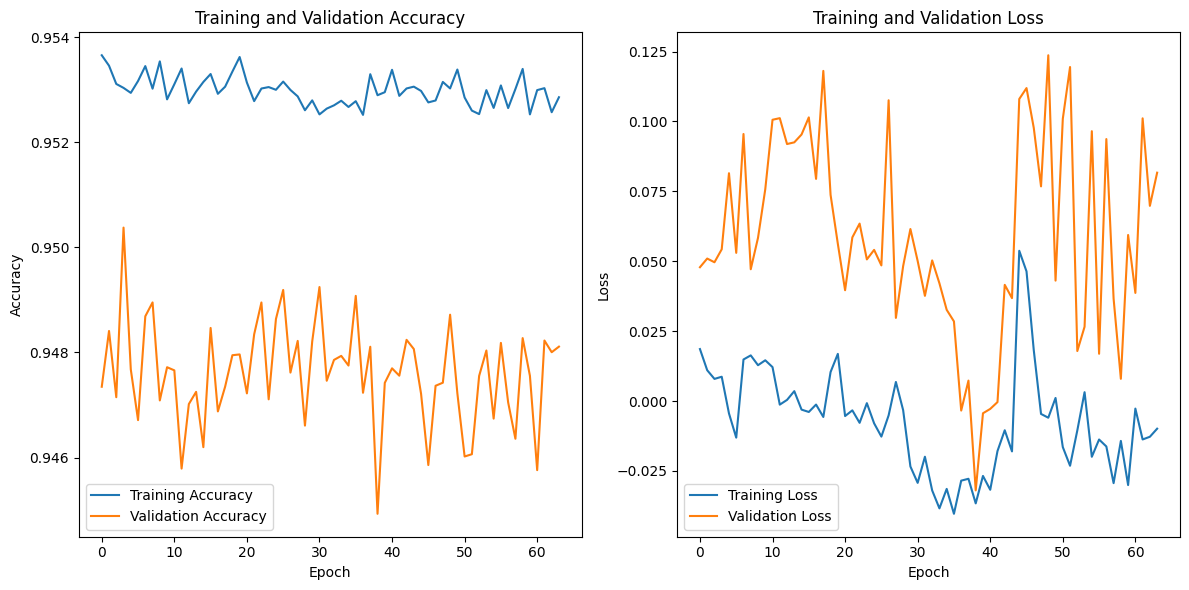

In [25]:
import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit
# history = model.fit(...)

# Extract the training and validation accuracy/loss from the history object
train_accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Create the plot for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Create the plot for loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# prompt: plot the result of 1st 5 rows intestdataset

import matplotlib.pyplot as plt
n_rows = 5
n_features = train_inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES
fig = plt.figure(figsize=(15, 6.5))

for i in range(n_rows):
  plt.subplot(n_rows, 2, i * 2 + 1)
  plt.imshow(train_labels[i, :, :], cmap=CMAP, norm=NORM)
  plt.title('Actual Fire Mask')
  plt.axis('off')

  plt.subplot(n_rows, 2, i * 2 + 2)
  predicted_output = model.predict(tf.expand_dims(train_inputs[i], axis=0))
  plt.imshow(predicted_output[0, :, :, 0], cmap=CMAP, norm=NORM)
  plt.title('Predicted Fire Mask')
  plt.axis('off')

plt.tight_layout()
plt.show()


In [72]:
TITLES_Result = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Model\nPrediction'
]

1/1 [==============================] - 0s 34ms/step


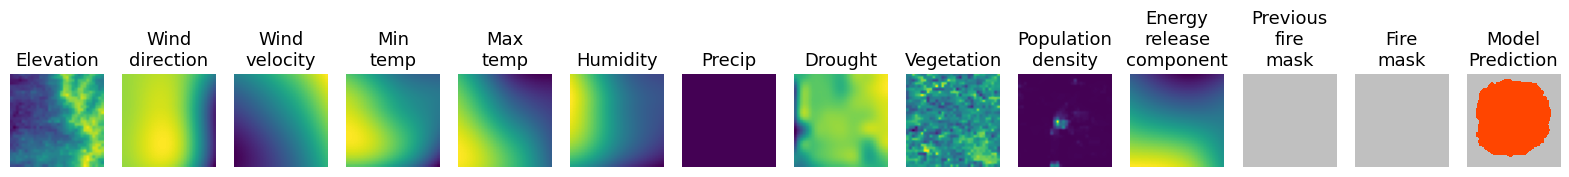

1/1 [==============================] - 0s 23ms/step


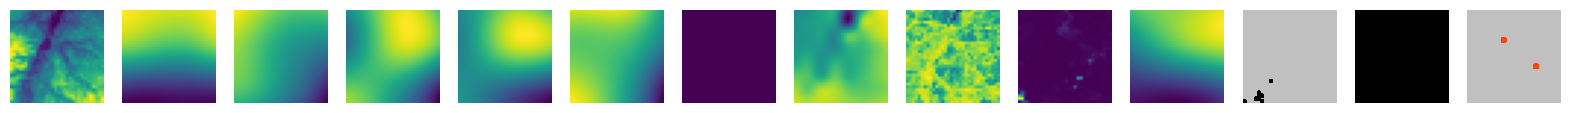

1/1 [==============================] - 0s 23ms/step


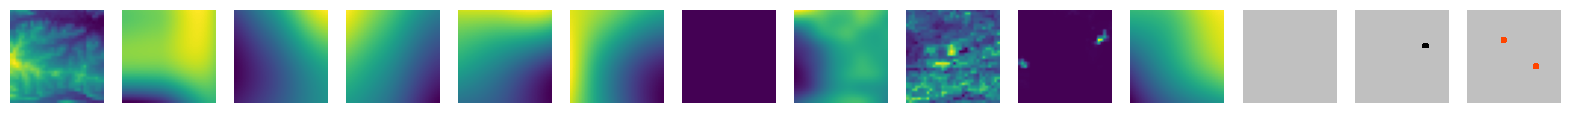

1/1 [==============================] - 0s 23ms/step


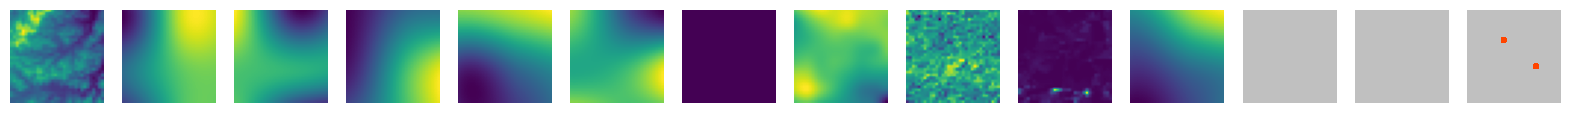

1/1 [==============================] - 0s 23ms/step


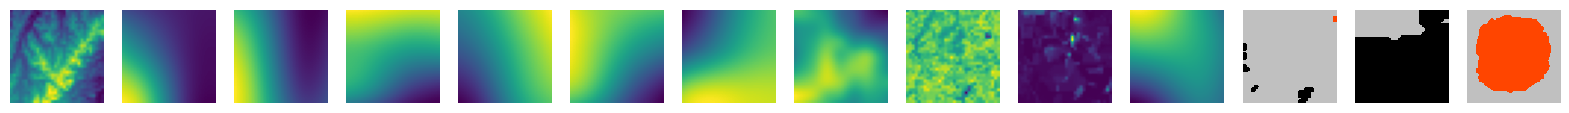

In [77]:
import matplotlib.pyplot as plt

# Assuming you have predictions from your model

# Choose a few examples to visualize
num_examples = 5

for i in range(num_examples):
  fig = plt.figure(figsize=(20,10))
  predicted_output = model.predict(tf.expand_dims(train_inputs[i], axis=0))
  for j in range(n_features + 2):
    # The error was in this line. The index for the subplot was calculated incorrectly
    plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1) # Changed n_features + 1 to n_features + 2 to reflect the correct number of columns
    if i == 0:
      plt.title(TITLES_Result[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(test_inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(test_inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(test_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j ==n_features+1:
      plt.imshow(predicted_output[0, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
  plt.show()

In [81]:

import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from ncps.wirings import AutoNCP
from ncps.tf import CfC
import pickle
import matplotlib.pyplot as plt
import time

# Define image parameters
img_width, img_height = 64, 64

test_dataset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)
test_inputs, test_labels = next(iter(test_dataset))



# Define the path to the trained_model_parameters folder
parameter_folder = '/content/'

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/CNN_weights_1.h5')
loaded_model._name = "MobileNetV2"

# CfC Layer with NCP implemented
ncp = CfC(36, AutoNCP(128, 32))

# Build a new model on top of the base MobileNetV2 model
model = Sequential([
    base_model,
    Reshape((1, 1280)),
    ncp,
    Dense(1024, activation='softmax'),  # Example dense layer
    Reshape((32, 32, 1))

    # Add more layers as needed
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Load the trainable parameters of the NCP layer
loaded_ncp_weights = pickle.load(open('/content/CfC_NCP_weights_1.pkl', 'rb'))
ncp.set_weights(loaded_ncp_weights)

# Load the weights of the last dense layer
loaded_last_dense_layer_weights = pickle.load(open('/content/last_dense_layer_weights_1.pkl', 'rb'))
model.layers[-1].set_weights(loaded_last_dense_layer_weights)
model._name = "Proposed_MobileNetV2_CfC_NCP"

import time
# Make predictions on the validation set
start_time = time.time()
test_predictions = model.predict(test_input)
end_time = time.time()
test_pred_labels = np.argmax(test_predictions, axis=1)
# Calculate the inference time
inference_time = end_time - start_time

# Print the Confusion Matrix using confusion_matrix element in Sklearn.
from sklearn import metrics
print("Confusion Matrix: ")
print(metrics.confusion_matrix(test_labels, test_pred_labels))
print("\n")

# Print the Classification Report using classification_report element in Sklearn.
from sklearn.metrics import classification_report
print("Classification Report: ")
print( classification_report(test_labels, test_pred_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# Calculate and print the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, test_pred_labels)
precision = precision_score(test_labels, test_pred_labels, average='macro')
recall = recall_score(test_labels, test_pred_labels, average='macro')
f1 = f1_score(test_labels, test_pred_labels, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

print("\n")

print("Average inference time per sample (second):", inference_time / len(test_images))

print("\n")

# Print out the layer structure
model.summary()

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("\n")
print("FLOPs: ", get_flops(model))

ValueError: Unknown layer: 'MixedMemoryRNN'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [55]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from ncps.wirings import AutoNCP
from ncps.tf import CfC
import pickle
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

# Load the pre-trained MobileNetV2 model
base_model = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 12))

print(base_model.summary())

# CfC Layer with NCP implemented
ncp = CfC(36, AutoNCP(128, 32))

# Build a new model on top of the base MobileNetV2 model
model = Sequential([
    base_model,
    Reshape((1, 2048)),
    ncp,
    Dense(1024, activation='softmax'),  # Example dense layer
    Reshape((32, 32, 1))

    # Add more layers as needed
])

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Define the temporary filepath to save the best weights
best_weights_filepath = 'best_weights_resnet50.h5'

# Define the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
# Train the model with the callbacks
print(train_inputs.shape)
print(train_labels.shape)

# Squeeze the tensors to remove dimensions of size 1
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Determine the new shape you want
# For example, if you want to flatten them
train_labels = tf.reshape(train_labels,[-1])
val_labels = tf.reshape(val_labels, [-1])

print(train_labels.shape)
print(val_labels.shape)
model.fit(train_dataset, epochs=200, batch_size=100, validation_data=(val_dataset), callbacks=[early_stopping_callback, save_best_weights_callback])


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 32, 32, 12)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 12)           0         ['input_17[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           37696     ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

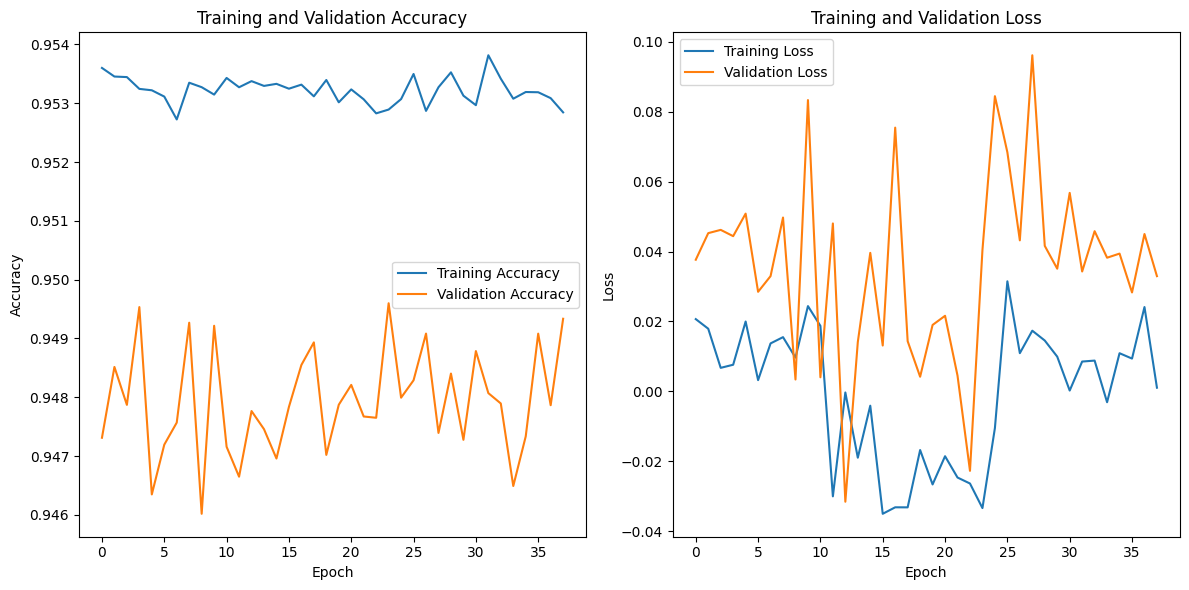

In [56]:
import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit
# history = model.fit(...)

# Extract the training and validation accuracy/loss from the history object
train_accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Create the plot for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Create the plot for loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [65]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load the pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(include_top=False, weights=None, input_shape=(32, 32, 12))

# Get the features from the CNN
cnn_output = base_model.output  # Shape will be (batch_size, 1, 1, 1280)

# Reshape the CNN output to make it 2D, which is required for LDA
cnn_output_flat = tf.keras.layers.Reshape((1280,))(cnn_output)  # Flatten to (batch_size, 1280)

def apply_lda(train_data, num_classes):
    lda = LinearDiscriminantAnalysis(n_components=num_classes - 1)  # num_classes is the number of output classes

    # Reshape only the feature data for each image individually
    train_inputs_lda = train_inputs.reshape(train_inputs.shape[0], -1)
    train_labels_lda = train_labels.reshape(-1)
    lda_transformed_data = lda.fit_transform(train_inputs_lda, train_labels_lda)  # Apply LDA transformation
    return lda_transformed_data

# In your training loop, extract the features and apply LDA
# Assume train_features is the feature data from CNN
train_features_np = apply_lda(train_dataset, num_classes=10)  # Example with 10 classes

# Convert back to TensorFlow tensor to pass to the RNN
train_features_tf = tf.convert_to_tensor(train_features_np, dtype=tf.float32)

# CfC Layer with NCP implemented
ncp = CfC(36, AutoNCP(128, 32))

# Build the final model
model = Sequential([
    base_model,
    Reshape((1280,)),  # Flatten CNN output for LDA
    Dense(1024, activation='relu'),  # Example dense layer
    Reshape((1, 1280)),  # Reshape to pass into RNN
    ncp,
    Dense(10, activation='softmax')  # Adjust based on the number of classes
])

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model (using pre-transformed LDA features)
model.fit(train_features_tf, train_labels, epochs=200, batch_size=100, validation_data=(val_features_tf, val_labels), callbacks=[early_stopping_callback, save_best_weights_callback])


AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      